In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

In [ ]:
# scikit-learn에서 데이터셋 받아오고 확인하기

california = fetch_california_housing()
df = pd.DataFrame(california.data, columns=california.feature_names)
df["Target"] = california.target
print(df.tail())

       MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
20635  1.5603      25.0  5.045455   1.133333       845.0  2.560606     39.48   
20636  2.5568      18.0  6.114035   1.315789       356.0  3.122807     39.49   
20637  1.7000      17.0  5.205543   1.120092      1007.0  2.325635     39.43   
20638  1.8672      18.0  5.329513   1.171920       741.0  2.123209     39.43   
20639  2.3886      16.0  5.254717   1.162264      1387.0  2.616981     39.37   

       Longitude  Target  
20635    -121.09   0.781  
20636    -121.21   0.771  
20637    -121.22   0.923  
20638    -121.32   0.847  
20639    -121.24   0.894  


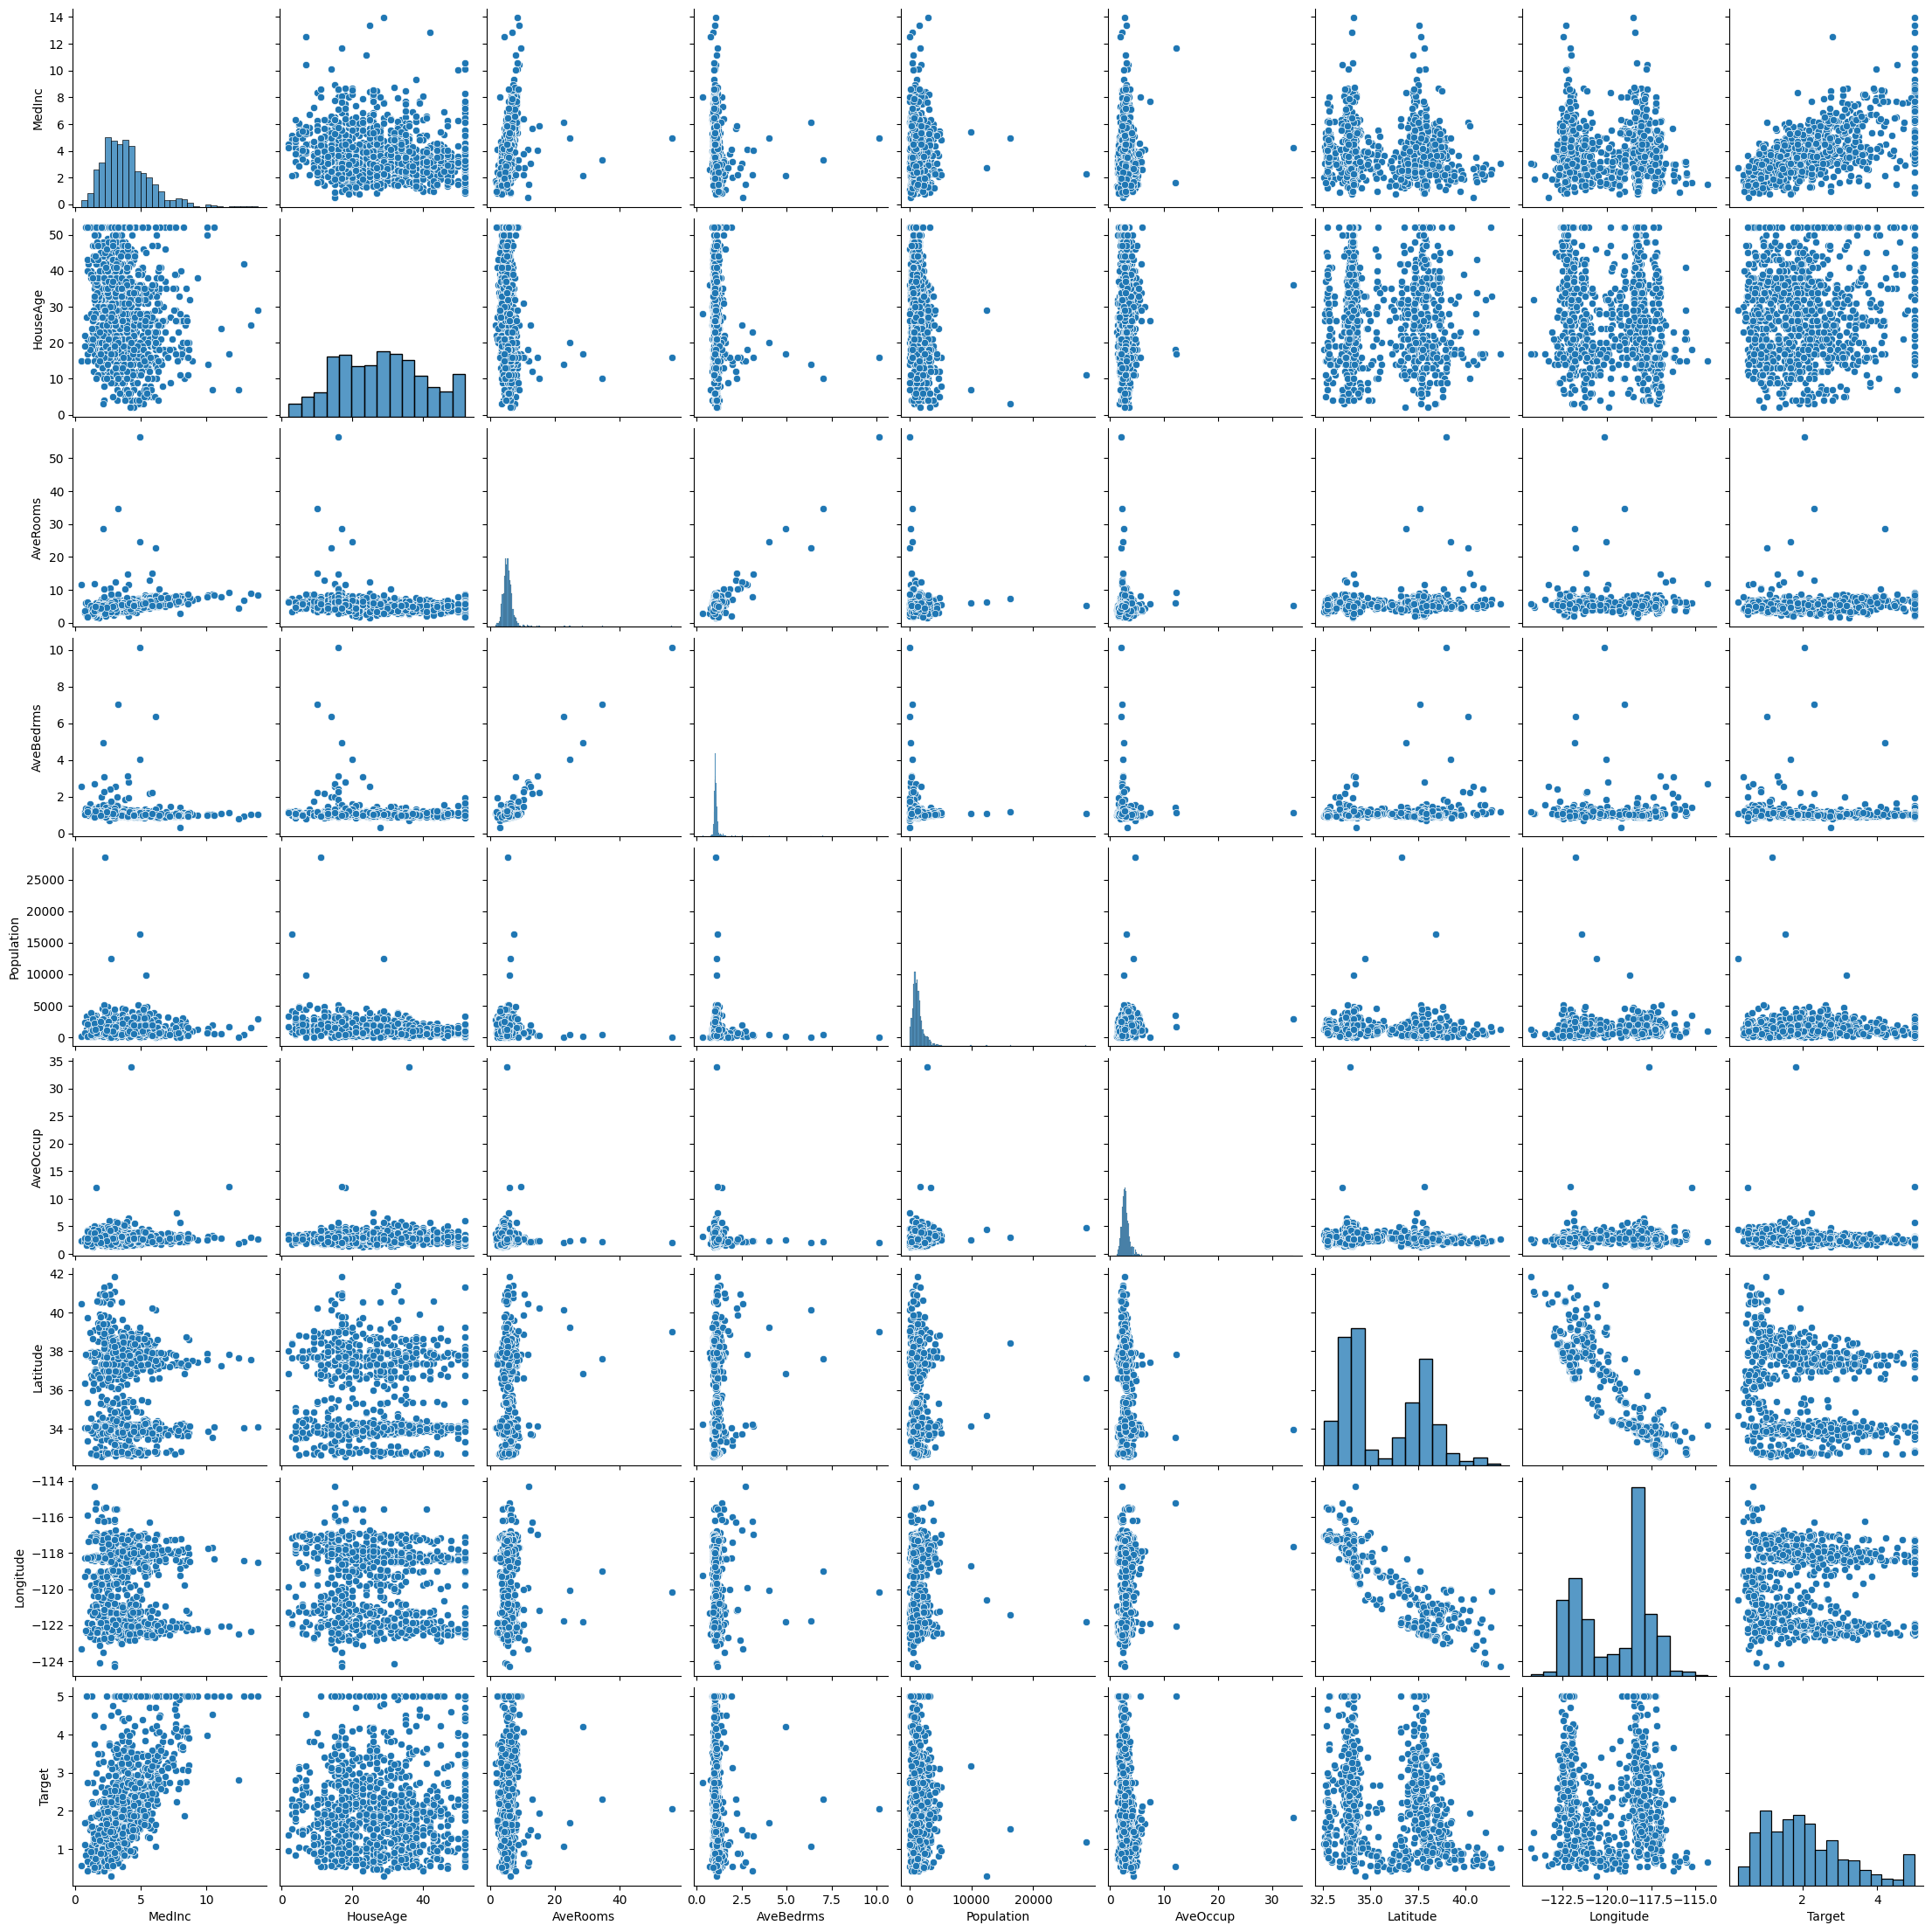

In [ ]:
# 데이터 시각화

sns.pairplot(df.sample(1000))
plt.show()

In [ ]:
# 데이터 정규화

scaler = StandardScaler()
df.iloc[:, :-1] = scaler.fit_transform(df.iloc[:, :-1])
print(df.tail())


         MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
20635 -1.216128 -0.289187 -0.155023   0.077354   -0.512592 -0.049110   
20636 -0.691593 -0.845393  0.276881   0.462365   -0.944405  0.005021   
20637 -1.142593 -0.924851 -0.090318   0.049414   -0.369537 -0.071735   
20638 -1.054583 -0.845393 -0.040211   0.158778   -0.604429 -0.091225   
20639 -0.780129 -1.004309 -0.070443   0.138403   -0.033977 -0.043682   

       Latitude  Longitude  Target  
20635  1.801647  -0.758826   0.781  
20636  1.806329  -0.818722   0.771  
20637  1.778237  -0.823713   0.923  
20638  1.778237  -0.873626   0.847  
20639  1.750146  -0.833696   0.894  


In [5]:
# 데이터 준비
data = torch.from_numpy(df.values).float()

x = data[:, :-1]    # 마지막 행을 제외한 행들을 x로 설정
y = data[:, -1:]    # 마지막 행만 y로 설정

print(x.shape, y.shape)

# 학습 설정
epochs = 4000       # 학습 반복 횟수
batch_size = 256    # 배치 사이즈
lr = 1e-2           # 학습률
interval = 200      # 학습 결과를 출력할 간격

torch.Size([20640, 8]) torch.Size([20640, 1])


In [6]:
# 모델 정의

model = nn.Sequential(
    nn.Linear(x.size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y.size(-1))
)

print(model)
optimizer = optim.SGD(model.parameters(), lr=lr) # 옵티마이저 함수로 확률적 경사 하강법 사용

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)


In [ ]:
# 모델 학습
for i in range(epochs):
    # 데이터 섞기 (무작위 인덱스 생성)
    indices = torch.randperm(x.size(0))

    # 입력 데이터와 정답 레이블을 같은 순서로 섞음
    x_ = torch.index_select(x, dim=0, index=indices)
    y_ = torch.index_select(y, dim=0, index=indices)

    # 미니 배치로 분할
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    y_hat = []                          # 예측값을 저장할 리스트
    total_loss = 0                      # 전체 loss 누적값 초기화

    # 각 미니 배치에 대해 학습
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)            # 모델 예측값 계산
        loss = F.mse_loss(y_hat_i, y_i) # MSE 손실 계산

        optimizer.zero_grad()           # 기울기 초기화
        loss.backward()                 # 역전파로 기울기 계산
        optimizer.step()                # 가중치 업데이트

        total_loss += float(loss)       # 손실 누적
        y_hat += [y_hat_i]              # 예측값 저장
        
    total_loss /= len(x_)               # epoch별 평균 손실 계산

    # 학습 진행 상황 출력
    if (i + 1) % interval == 0:
        print('Epoch %d: loss=%.4e' % (i + 1, total_loss))

# 전체 예측값과 정답 레이블을 하나로 합치기
y_hat = torch.cat(y_hat, dim=0)
y = torch.cat(y_, dim=0)

Epoch 200: loss=1.3320e+00
Epoch 400: loss=1.3328e+00
Epoch 600: loss=3.2567e-01
Epoch 800: loss=2.9343e-01
Epoch 1000: loss=2.8801e-01
Epoch 1200: loss=2.8582e-01
Epoch 1400: loss=2.8448e-01
Epoch 1600: loss=2.8456e-01
Epoch 1800: loss=2.8493e-01
Epoch 2000: loss=2.8360e-01
Epoch 2200: loss=2.8390e-01
Epoch 2400: loss=2.8394e-01
Epoch 2600: loss=2.8333e-01
Epoch 2800: loss=2.8336e-01
Epoch 3000: loss=2.8182e-01
Epoch 3200: loss=2.8225e-01
Epoch 3400: loss=2.8198e-01
Epoch 3600: loss=2.8148e-01
Epoch 3800: loss=2.8174e-01
Epoch 4000: loss=2.8248e-01


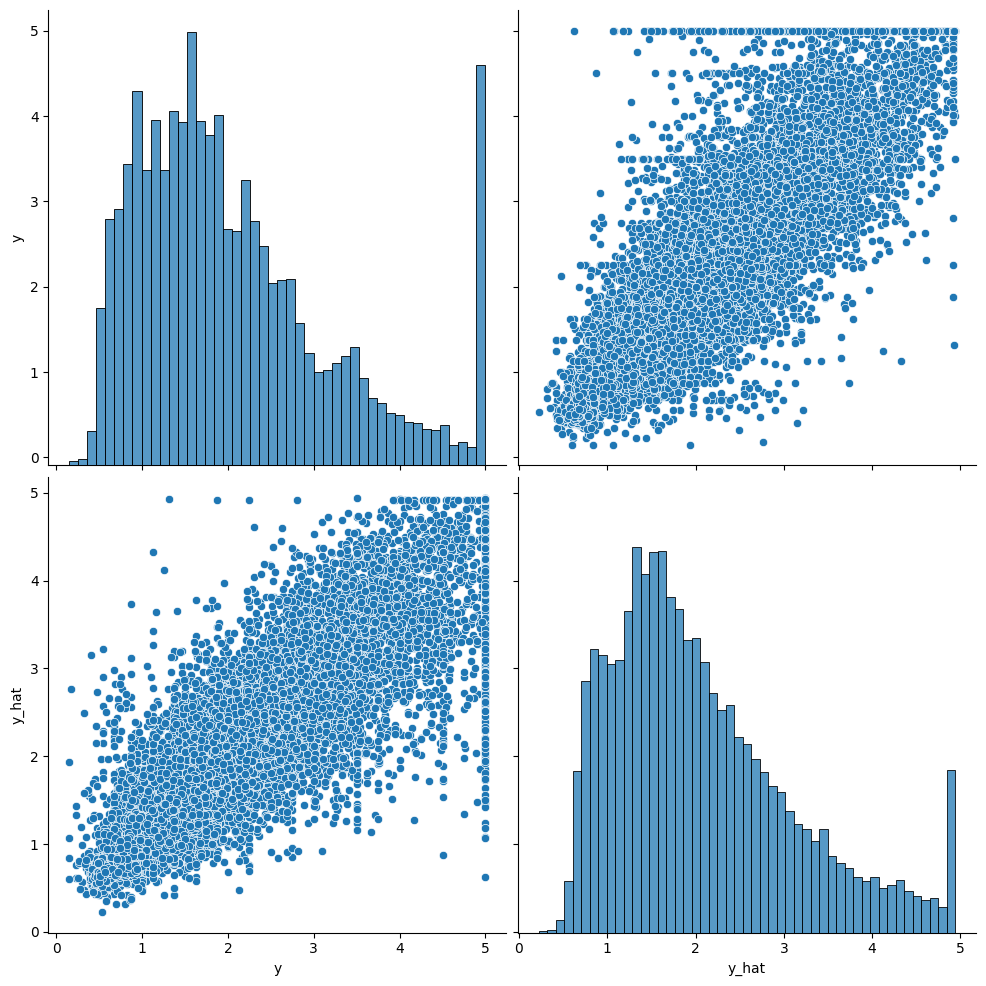

In [8]:
# 결과 시각화

df = pd.DataFrame(torch.cat([y, y_hat], dim=1).detach().numpy(), columns=["y", "y_hat"])

sns.pairplot(df, height=5)
plt.show()